In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [2]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original

def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'

df['quality_category'] = df['quality'].apply(categorize_quality)

red_wine_df = df[df['color'] == 'red']
white_wine_df = df[df['color'] == 'white']

df_array = [red_wine_df, white_wine_df, df]

In [3]:
df_names = ['Red Wine', 'White Wine', 'Combined Wine']

def confusion_matrix_plot(y_test, y_pred, clf, model):
    # Create both normalized and raw confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true class
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=clf.classes_)
    disp1.plot(cmap=plt.cm.Blues, ax=ax1, values_format='d')
    ax1.set_title(f'Confusion Matrix (Raw Counts)\n{model.__class__.__name__}')
    
    # Normalized confusion matrix (shows percentages for each true class)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=clf.classes_)
    disp2.plot(cmap=plt.cm.Blues, ax=ax2, values_format='.2f')
    ax2.set_title(f'Confusion Matrix (Normalized)\n{model.__class__.__name__}')
    
    plt.tight_layout()
    plt.show()

def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0
    
    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds
    
    print(f"Best Folds: {best_folds} | Best Score: {best_score}", end=" | ")
    return best_folds

def pr_curve(y_test, y_scores, model):
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='good')
    
    # Calculate Average Precision (area under PR curve)
    ap_score = average_precision_score(y_test, y_scores, pos_label='good')
    
    # Calculate baseline (random classifier performance)
    baseline = len(y_test[y_test == 'good']) / len(y_test)
    
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1, 
                label=f'Random Baseline (AP = {baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add text box with key metrics
    textstr = f'Average Precision: {ap_score:.3f}\nBaseline: {baseline:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return ap_score


def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        # For models that support probability prediction
        probabilities = model.predict_proba(X_test)
        # Find the index of 'good' class
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'):
        # For models with decision function (like SVM without probability)
        return model.decision_function(X_test)
    else:
        # Fallback: use predicted class as binary score (not ideal for PR curve)
        predictions = model.predict(X_test)
        return (predictions == 'good').astype(int)

In [4]:
def descriminant_analysis(model, wine_df):
    # set up data
    X = wine_df.drop(columns=['quality', 'quality_category', 'color'])
    y = wine_df['quality_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # find optimized num
    folds = optimized_folds(model, X_train, y_train)

    # find optimixed priors
    priors = []
    for low_prior in np.arange(0.05, 0.36, 0.1):  
        high_prior = 1.0 - low_prior  
        priors.append([round(low_prior, 2), round(high_prior, 2)])

    param_grid = {'priors': priors}
    grid_search = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, cv=folds)
    grid_search.fit(X_train, y_train)

    clf = QuadraticDiscriminantAnalysis(priors=grid_search.best_params_["priors"])
    print(f'Best priors: {grid_search.best_params_["priors"]}')
    clf.fit(X_train, y_train)

    # Evalutation metrics
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    y_scores = get_probability_scores(clf, X_test)
    ap_score = pr_curve(y_test, y_scores, clf)
    
    confusion_matrix_plot(y_test, y_pred, clf, model)
    
    return clf

Processing Red Wine DataFrame
quality_category
bad     1382
good     217
Name: count, dtype: int64
Best Folds: 4 | Best Score: 0.706139324954246 | Best priors: [0.35, 0.65]
              precision    recall  f1-score   support

         bad       0.97      0.68      0.80       415
        good       0.30      0.86      0.44        65

    accuracy                           0.71       480
   macro avg       0.63      0.77      0.62       480
weighted avg       0.88      0.71      0.75       480



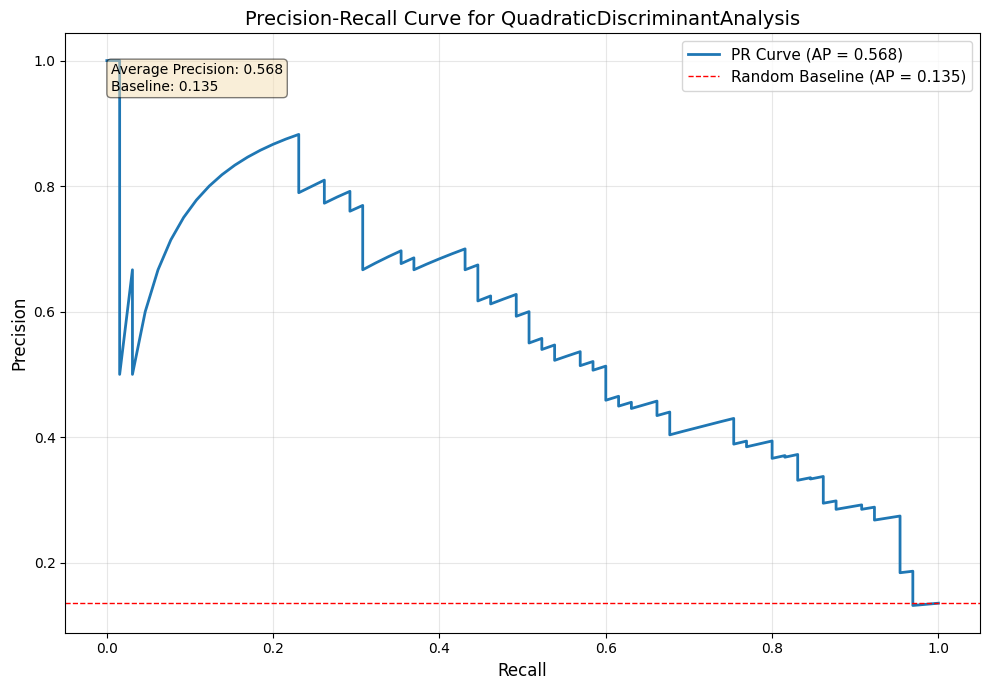

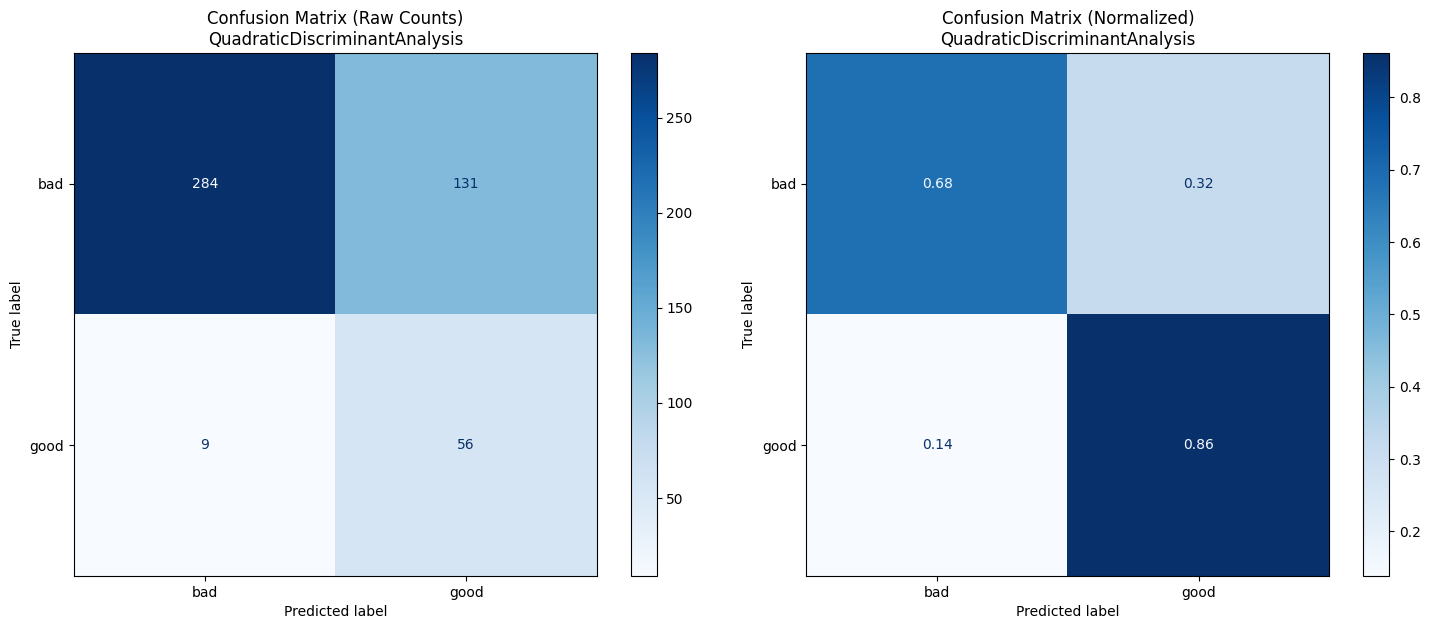

Processing White Wine DataFrame
quality_category
bad     3838
good    1060
Name: count, dtype: int64
Best Folds: 6 | Best Score: 0.6912109677615456 | Best priors: [0.35, 0.65]
              precision    recall  f1-score   support

         bad       0.96      0.51      0.67      1152
        good       0.34      0.92      0.50       318

    accuracy                           0.60      1470
   macro avg       0.65      0.71      0.58      1470
weighted avg       0.82      0.60      0.63      1470

Best Folds: 6 | Best Score: 0.6912109677615456 | Best priors: [0.35, 0.65]
              precision    recall  f1-score   support

         bad       0.96      0.51      0.67      1152
        good       0.34      0.92      0.50       318

    accuracy                           0.60      1470
   macro avg       0.65      0.71      0.58      1470
weighted avg       0.82      0.60      0.63      1470



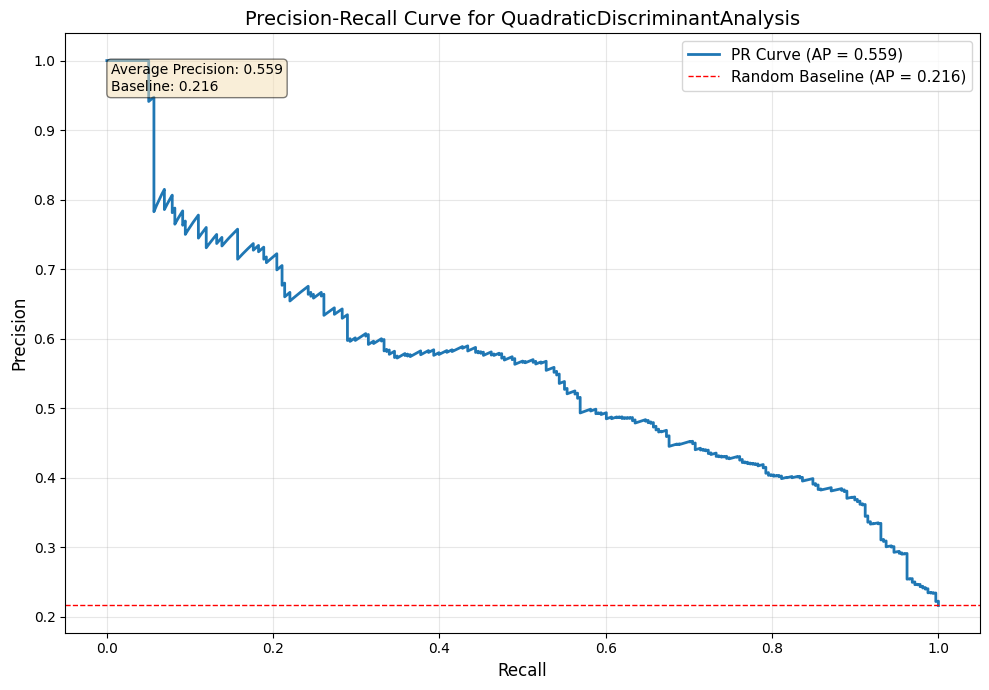

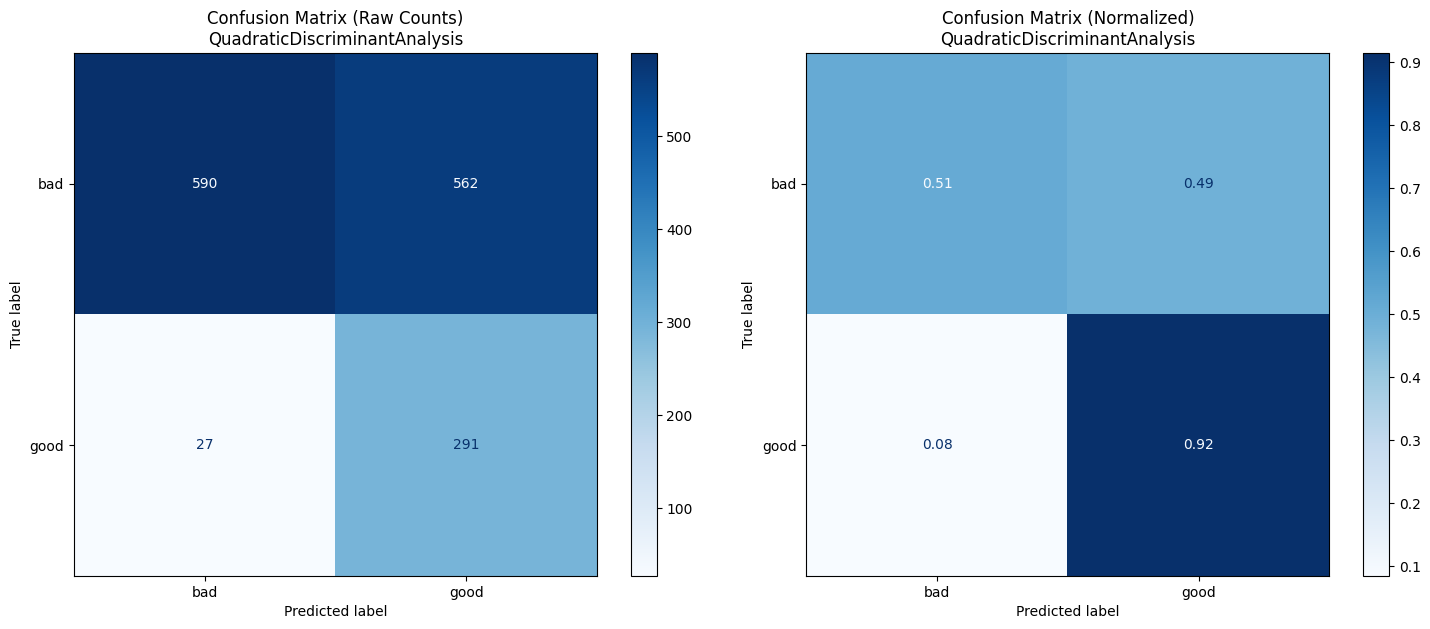

Processing Combined Wine DataFrame
quality_category
bad     5220
good    1277
Name: count, dtype: int64
Best Folds: 10 | Best Score: 0.7034651638714504 | Best priors: [0.35, 0.65]
              precision    recall  f1-score   support

         bad       0.96      0.53      0.68      1567
        good       0.32      0.91      0.47       383

    accuracy                           0.60      1950
   macro avg       0.64      0.72      0.58      1950
weighted avg       0.83      0.60      0.64      1950

Best Folds: 10 | Best Score: 0.7034651638714504 | Best priors: [0.35, 0.65]
              precision    recall  f1-score   support

         bad       0.96      0.53      0.68      1567
        good       0.32      0.91      0.47       383

    accuracy                           0.60      1950
   macro avg       0.64      0.72      0.58      1950
weighted avg       0.83      0.60      0.64      1950



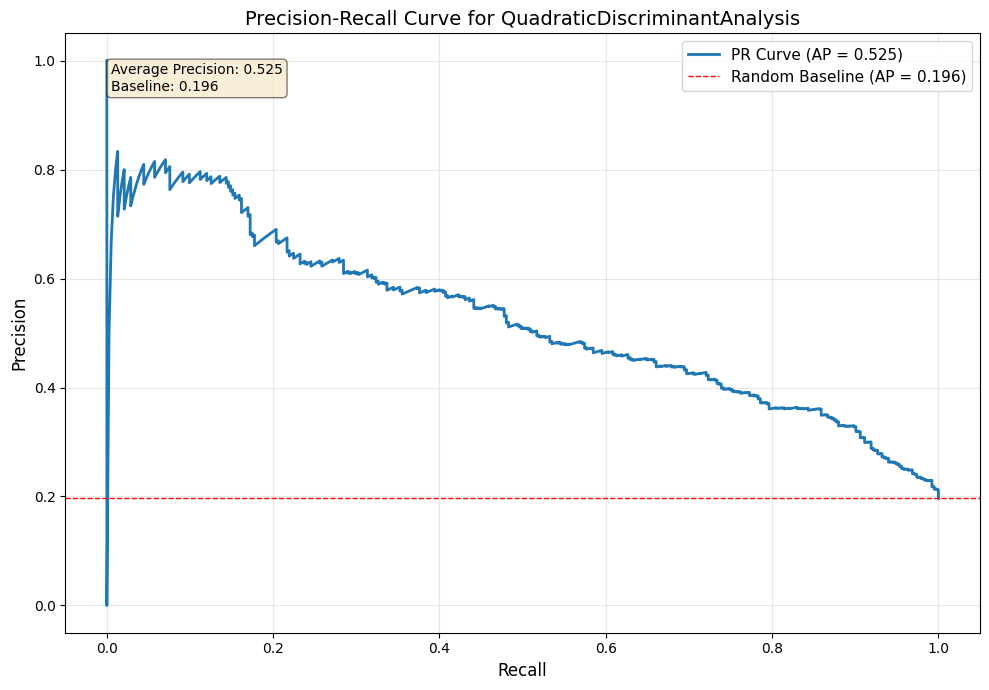

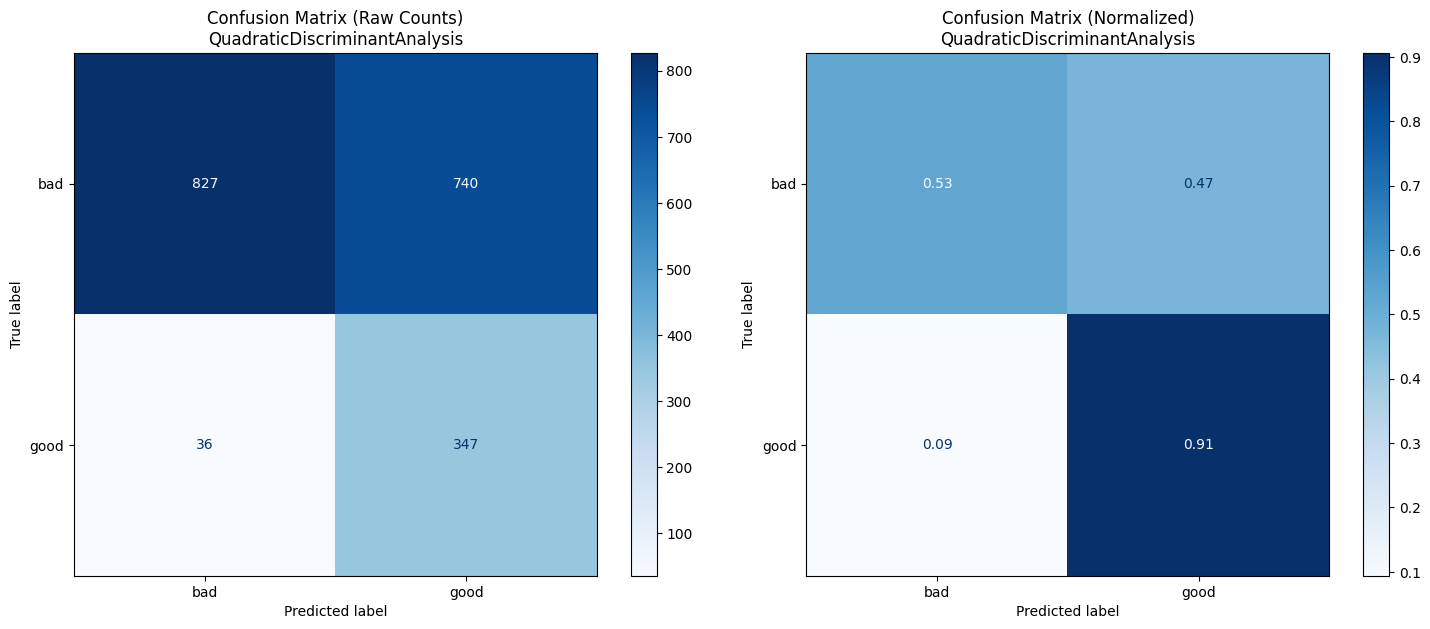

In [5]:
qda = QuadraticDiscriminantAnalysis()
lda = LinearDiscriminantAnalysis()

for i, wine_df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]} DataFrame")
    print("=" * 40)

    print(wine_df['quality_category'].value_counts())

    # qda and lda give same results
    descriminant_analysis(qda, wine_df)

## Analysis
1. doesnt matter between QDA and LDA 
2. worse the random forest